In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)

from liset_aux import ripples_std, middle


c:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\liset_tk']


In [3]:
# parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\Download_from_paper" # Modify this to your data path folder
# parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"
# parent=r"E:\neurospark_mat\Download_from_paper"

bandpass=[100,250]
downsampled_fs = False # Downsampled frequency
factor=downsampled_fs//1000 if downsampled_fs else 30
time_max=60
window_size=0.05
sample_ratio=0.25
scaling_factor=1
refractory=0

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs

# std, mean = ripples_std(parent) # 61 ms # in seconds
# INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data
INTERSECT_WINDOW_LEN=60 # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 60 (MEAN+STD)
WINDOW_SHIFT: 120
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
}

In [6]:
from signal_aid import most_active_channel, bandpass_filter


## Extract Windows
Extract UP/DN spike Windows


In [7]:
load=False

from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_dataa' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # from make_windows import *
        # windowed_input_data, windowed_gt, filtered_windows, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
        #              refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)
        from make_windows2 import *
        windowed_input_data, windowed_gt, filtered_windows,ripple_ids, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
                     refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)


Dataset:  Amigo2_2019-07-11_11-57-07
data shape:  (71965696, 8)
ripples shape:  (1309, 2)
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [13035600:13041000] has a GT event at [13034561 13035700] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [31784400:31789800] has a GT event at [31783259 31784528] and NO Input activations. Skipping...
[WARNING] Window [38080800:38086200] has a GT event at [38079680 38080982] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [13035600:13041000] has a GT event at [13034

In [8]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 2689989.0
Down Spikes Total: 2711897.0


In [9]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")
GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([287093,    144,    184,    159,    184,    239,    168,    176,    192,    216,    232,
          160,    244,    232,    160,    240,    248,    160,    200,    174, ...,     72,    136,
           80,     73,     96,     80,     48,     56,     40,     56,     40,     16,     40,
           16,     40,     32,     32,     40,     24,     32], dtype=int64))
Number of windows with an HFO: 23580
Percentage of windows with an HFO: 7.59%


In [10]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_ripples=ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 34503  28082  16177   9654  16312  15142   7750  10013  14639  26189  26181  39690   7758 216658
  10567 240046  15030   2984 208653  52503 ... 226686 162526  63166 252362 193650 254818 171303
 147684  90860  65859 128298 128297 269471  10938  83600 204853 110899  83602 263136 302249]
Sorted_data: (310673, 180, 2) | Sorted_gt: (310673,)| Sorted_filtered_windows: (310673, 5400)
Sorted_gt preview: [115.  67. 115.  67. 146. 148.  42. 129.  82.  76.]
GT first window: 115.0 | GT last window: -1.0


In [11]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")


Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 137., 138., 139., 140., 141., 142., 145., 146., 148.,
       150., 151., 152., 153., 156., 157., 159., 160., 163., 164., 170.], dtype=float32), array([190,   1,   5,  11,  10,   2,  10,   3,  10,   3,  17,   7,  18,  12,  23,   1,   8,   5,
         4,   5, ...,   5,   2,   6,   1,   1,   1,   8,   9,   6,   7,   1,   7,   5,   1,   1,
         1,   9,   1,   4,   4], dtype=int64))


180


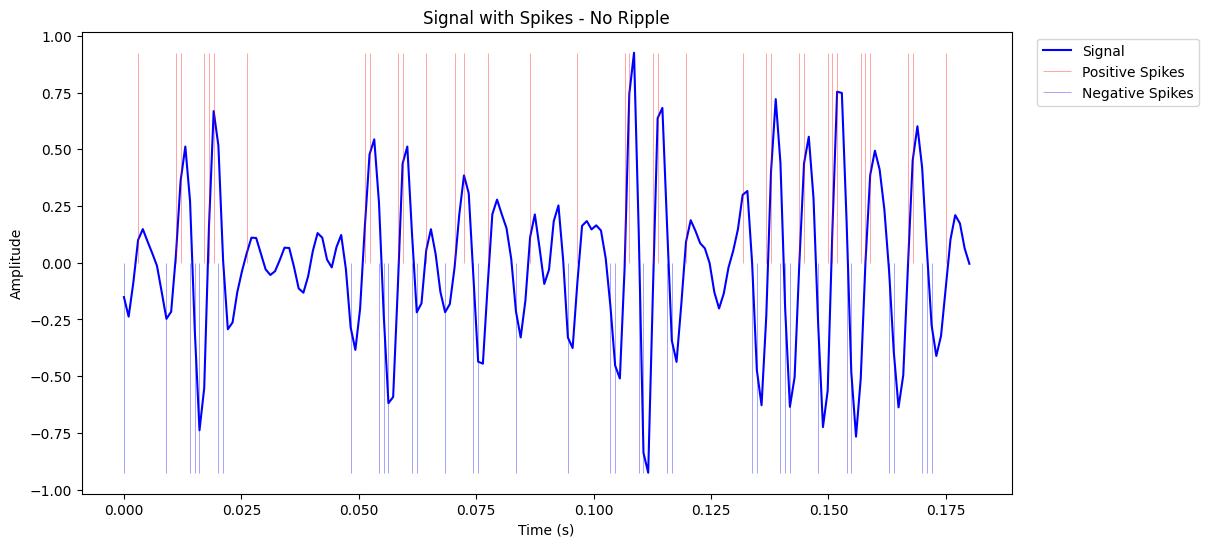

Total Spikes: 73.0
Up Spikes: 36.0
Down Spikes: 37.0


In [12]:
from snnTorch.utils.util import window_plot
window=900
plot_spikes=sorted_spikes[window,:,:]
# plot_filtered_window=sorted_filtered_windows[window,::factor]
plot_filtered_window=average_downsampling(sorted_filtered_windows[window,:], factor)
# plot_filtered_window=decimation_downsampling(sorted_filtered_windows[window,:], factor)


plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=1000,detection_window=RIPPLE_DETECTION_OFFSET)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [13]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [14]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(windowed_input_data)

# Print the average counts
average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")


Average HFO Up Counts: 18.018447837150127
Average HFO Down Counts: 18.41314673452078
Average Total HFO Counts: 36.43159457167091
Average Non-HFO Up Counts: 7.889826641541243
Average Non-HFO Down Counts: 7.933718342140003
Average Total Non-HFO Counts: 15.823544983681247
Average Total Counts: 17.38769059429046


In [15]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


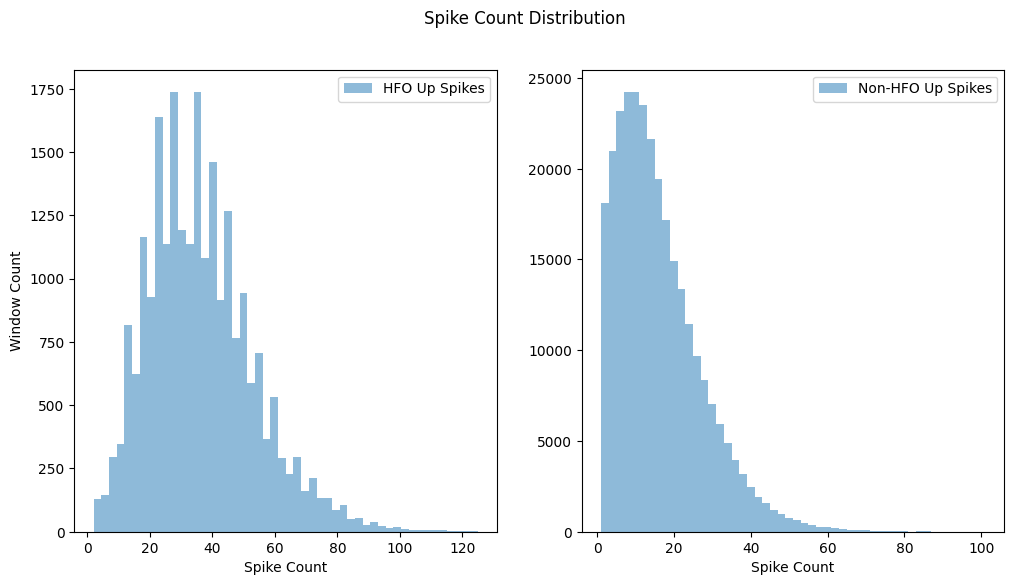

In [16]:
plt.subplots(1,2, figsize=(12, 6))
plt.suptitle('Spike Count Distribution')
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.xlabel('Spike Count')
plt.show()

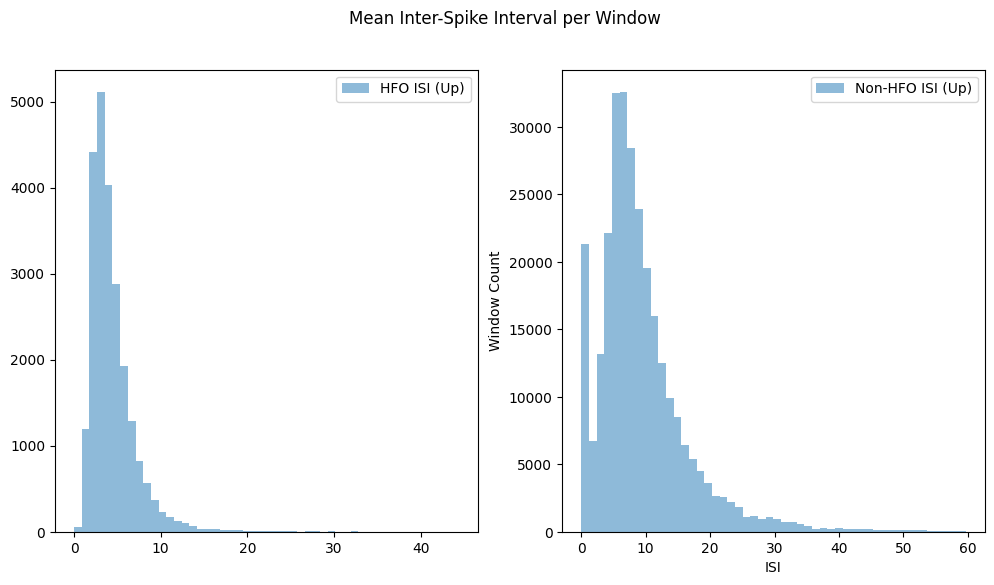

In [17]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean, bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean, bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

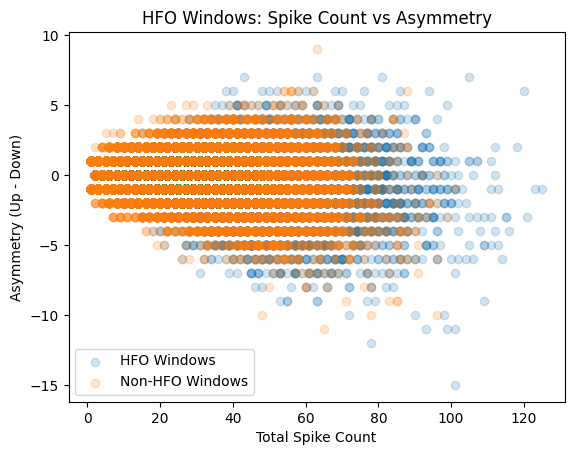

In [18]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process Windows

In [19]:
p1_windowed_input_data,p1_windowed_gt,p1_ripple_ids=only_some_channels_per_ripple(windowed_input_data,windowed_gt,ripple_ids,1)


In [20]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p1_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p1_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p1_windowed_gt.shape[0] * 100:.2f}%")



Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([287093,     14,     14,     12,     19,     25,     14,     19,     20,     19,     20,
           16,     24,     25,     15,     26,     25,     18,     20,     21, ...,      4,      7,
            4,      5,      4,      6,      2,      5,      1,      5,      1,      1,      1,
            2,      1,      1,      2,      2,      2,      1], dtype=int64))
Number of windows with an HFO: 2702
Percentage of windows with an HFO: 0.93%


In [21]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p1_windowed_input_data[:, :, 0], axis=1) + np.sum(p1_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p1_windowed_input_data[sorted_indices]
sorted_gt= p1_windowed_gt[sorted_indices]
sorted_ripples=p1_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [288189 287796 288209 288127 287549 287844 288085 287553 288628 287306 288117 287902 287877 287987
 287659 287540 287507 287208 288149 287376 ... 258718  63546  70766 167268 132562  43502   2370
 247960 192509 142525 192510 260296 150633 192511 170161 286951 278469 283129 214111 163015]
Sorted_data: (289795, 180, 2) | Sorted_gt: (289795,)
Sorted_gt preview: [115.  67. 146. 148.  42. 129.  82.  76.  33.  38.]
GT first window: 115.0 | GT last window: -1.0


In [22]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 140., 141., 142., 143., 144., 145., 146., 148., 150.,
       151., 152., 153., 154., 156., 159., 160., 164., 166., 167., 170.], dtype=float32), array([513,   3,   4,   3,   5,   5,   7,   4,   5,   3,   6,   3,   9,   5,   6,   2,   3,   3,
         5,   6, ...,   2,   1,   2,   1,   1,   6,   3,   3,   2,   1,   4,   2,   1,   1,   1,
         2,   2,   1,   1,   1], dtype=int64))


In [23]:
is_hfo = p1_windowed_gt >= 0
hfo_windows = p1_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p1_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [24]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p1_windowed_input_data)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 24.44855662472243
Average HFO Down Counts: 25.162102146558105
Average Total HFO Counts: 49.610658771280534
Average Non-HFO Up Counts: 7.889826641541243
Average Non-HFO Down Counts: 7.933718342140003
Average Total Non-HFO Counts: 15.823544983681247
Average Total Counts: 16.138570368708915


In [25]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


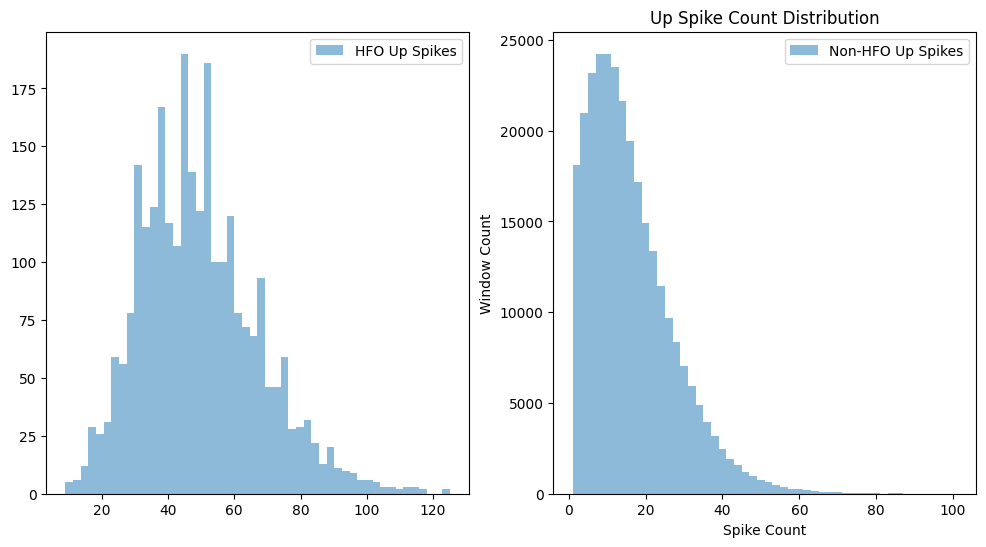

In [26]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

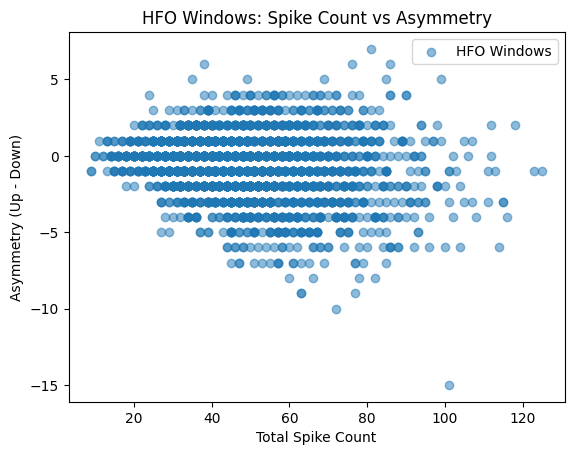

In [27]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process - Remove Windows above thresholds

In [75]:
thresholds=[average_total_counts,average_total_counts*10]
# p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold(p1_windowed_input_data,p1_windowed_gt,
#                                                                          p1_ripple_ids,MEAN_DETECTION_OFFSET,thresholds)
p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold_prob(windowed_input_data,windowed_gt,
                                                                         ripple_ids,MEAN_DETECTION_OFFSET,thresholds,max_prob=1)

False Negative Removed (Prob 0.87) - Spikes: 23.0
False Negative Removed (Prob 0.96) - Spikes: 24.0
False Positive Removed (Prob 0.90) - Spikes: 12.0
False Negative Removed (Prob 1.00) - Spikes: 31.0
False Negative Removed (Prob 1.00) - Spikes: 25.0
False Positive Removed (Prob 0.66) - Spikes: 42.0
False Negative Removed (Prob 1.00) - Spikes: 34.0
False Positive Removed (Prob 0.74) - Spikes: 32.0
False Negative Removed (Prob 1.00) - Spikes: 32.0
False Negative Removed (Prob 1.00) - Spikes: 41.0
False Negative Removed (Prob 1.00) - Spikes: 46.0
False Negative Removed (Prob 1.00) - Spikes: 36.0
False Negative Removed (Prob 0.47) - Spikes: 18.0
False Negative Removed (Prob 1.00) - Spikes: 27.0
False Negative Removed (Prob 1.00) - Spikes: 28.0
False Negative Removed (Prob 0.63) - Spikes: 20.0
False Negative Removed (Prob 1.00) - Spikes: 33.0
False Negative Removed (Prob 0.96) - Spikes: 24.0
False Negative Removed (Prob 1.00) - Spikes: 31.0
False Positive Removed (Prob 0.73) - Spikes: 33.0


In [76]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p2_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p2_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p2_windowed_gt.shape[0] * 100:.2f}%")

Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([187745,     45,     70,     42,     64,     55,     62,     49,     68,     62,     61,
           43,     80,     65,     50,     68,     76,     47,     59,     52, ...,     10,     28,
           14,     10,     16,     10,      5,      9,      1,     12,      4,      4,      5,
            5,      9,      2,      1,      7,      3,      1], dtype=int64))
Number of windows with an HFO: 5624
Percentage of windows with an HFO: 2.91%


In [77]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p2_windowed_input_data[:, :, 0], axis=1) + np.sum(p2_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p2_windowed_input_data[sorted_indices]
sorted_gt= p2_windowed_gt[sorted_indices]
sorted_ripples=p2_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 15328  12655   7038   4779   7088   4915   4025   6462  11909  11912 132835  17918   4028   1829
 147320  20257  24772 137513 128102   5073 ...  28692 103826  66349  66353 107938  28700  37825
 169297 135237 113850 157101 164626 164634 154285 103875  52114  66428  37788  66453 150051]
Sorted_data: (193369, 180, 2) | Sorted_gt: (193369,)
Sorted_gt preview: [115.  67. 115.  67. 146. 129.  42.  82.  42.  76.]
GT first window: 115.0 | GT last window: -1.0


In [78]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ 31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50., ..., 141., 142., 143., 144., 145., 146., 148., 149., 150.,
       151., 152., 153., 154., 157., 159., 160., 163., 164., 166., 170.], dtype=float32), array([ 5, 12, 15, 14,  9, 18,  5, 12, 10, 17,  9, 21, 16, 19,  8, 11,  8,  8,  8,  9, ...,  3,  4,
        2,  2,  9,  4,  2,  1,  2,  3,  8,  3,  3,  1,  3,  6,  2,  2,  1,  2], dtype=int64))


In [79]:
is_hfo = p2_windowed_gt >= 0
hfo_windows = p2_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p2_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [82]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p2_windowed_input_data)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 21.81667852062589
Average HFO Down Counts: 22.388869132290186
Average Total HFO Counts: 44.205547652916074
Average Non-HFO Up Counts: 4.805496817491811
Average Non-HFO Down Counts: 4.817885962342539
Average Total Non-HFO Counts: 9.62338277983435
Average Total Counts: 10.629180478773744


In [83]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])

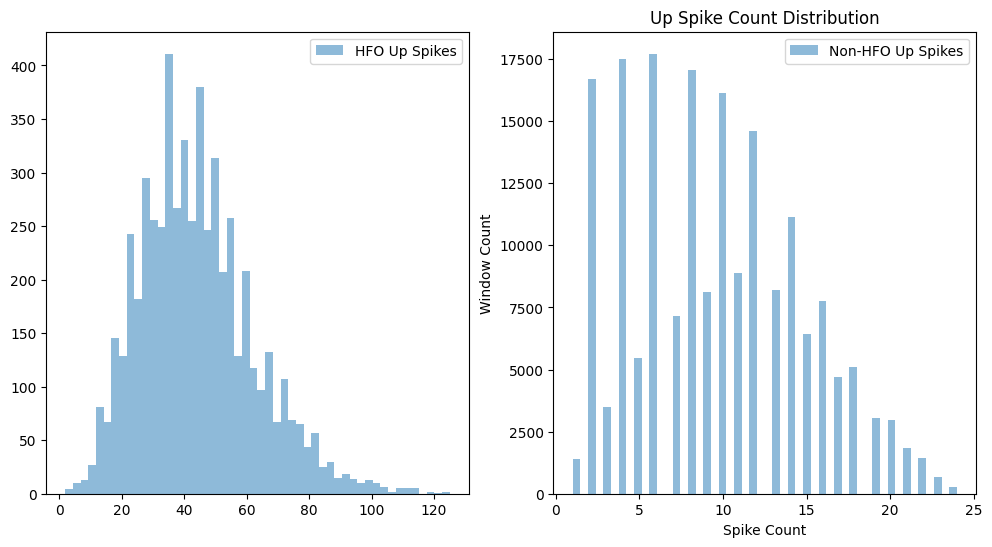

In [84]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

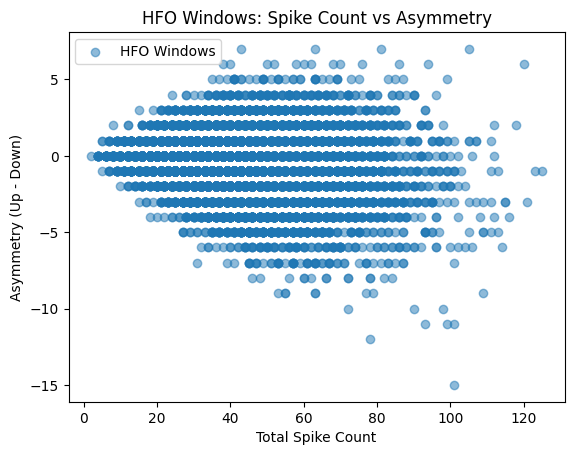

In [64]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## After Undersampling Non-Ripples

In [37]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    # intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt)
    intermediate_input, intermediate_gt = undersample_majority(p2_windowed_input_data, p2_windowed_gt)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([21098,   133,   173,   146,   174,   224,   162,   169,   183,   205,   216,   143,   227,
         219,   152,   221,   232,   152,   189,   163, ...,    55,   119,    63,    58,    73,
          65,    40,    41,    26,    50,    29,    13,    31,    16,    32,    22,    17,    30,
          18,    22], dtype=int64))
Intermediate Window Input Data Shape: (42196, 180, 2)


In [38]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)
print(f"Number of HFO windows: {hfo_windows.shape[0]}")
print(f"Number of Non-HFO windows: {non_hfo_windows.shape[0]}")

Number of HFO windows: 21098
Number of Non-HFO windows: 21098


In [39]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(intermediate_input)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 19.084557777988437
Average HFO Down Counts: 19.519433121622903
Average Total HFO Counts: 38.60399089961134
Average Non-HFO Up Counts: 6.261162195468764
Average Non-HFO Down Counts: 6.280737510664518
Average Total Non-HFO Counts: 12.541899706133282
Average Total Counts: 25.57294530287231


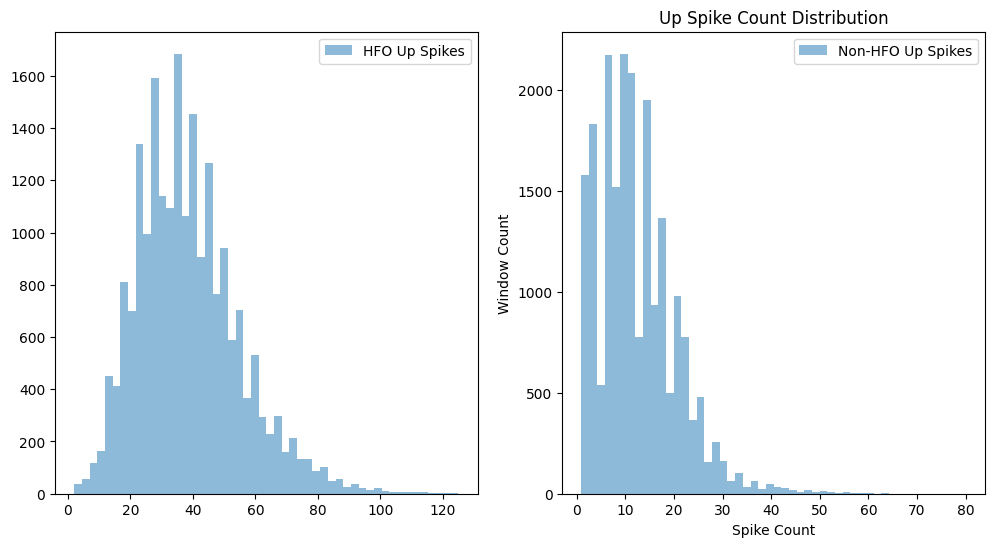

In [40]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

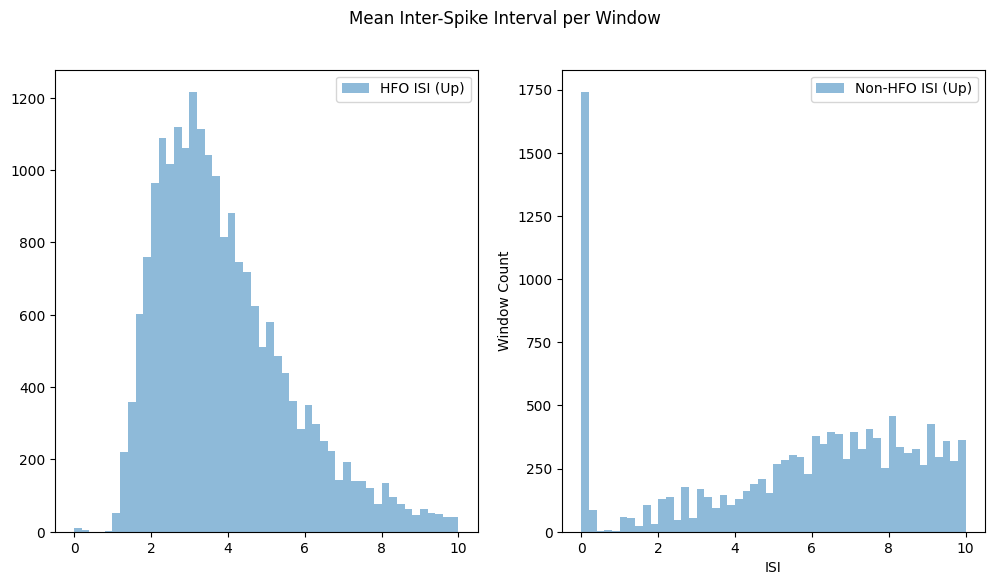

In [41]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

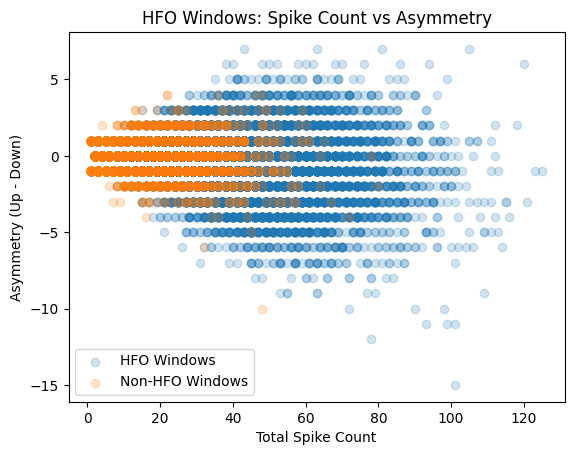

In [42]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

In [43]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)